In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout

import tensorflow
tensorflow.random.set_seed(2022)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout = go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('PGE_SA.csv').fillna('ffill')
df = df.sort_index(ascending=False)
df.index = range(len(df))
df['Data'] = pd.to_datetime(df['Data'])
df = df.rename(columns={'Maks.':'Maks'})
df = df.rename(columns={'Min.':'Min'})
df.head()

,Data,Otwarcie,Zamknięcie,Maks,Min,Obrót (mln. zł),Zmiana (%)
0,2012-04-19,14.05,14.24,14.40,13.99,70.06,0.00
1,2012-04-20,14.24,14.35,14.42,14.20,39.45,0.75
2,2012-04-23,14.24,14.06,14.34,13.91,37.70,-2.01
3,2012-04-24,13.92,13.86,14.04,13.85,28.37,-1.40
4,2012-04-25,13.92,13.93,14.16,13.87,48.42,0.44


### Shift label column

In [3]:
for i in range(1, 31):
    name = 'Otwarcie_' + str(i) + 'day'
    df[name] = df['Otwarcie'].shift(-i)
    name = 'Zamknięcie_' + str(i) + 'day'
    df[name] = df['Zamknięcie'].shift(i)

### Drop invalid samples

In [4]:
df = df.iloc[31:]
df = df[:-30]
df.index = range(len(df))

### Split data

In [5]:
test_size = 0.2

test_split_idx = int(df.shape[0] * (1-test_size))

train_df = df.loc[:test_split_idx].copy()
test_df = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Data, y=train_df.Otwarcie, name='Training'))
fig.add_trace(go.Scatter(x=test_df.Data, y=test_df.Otwarcie, name='Test'))
fig.show()

### Drop unnecessary columns

In [6]:
drop_cols = ['Data', 'Obrót (mln. zł)', 'Zmiana (%)', 'Otwarcie', 'Min', 'Maks']

train_df = train_df.drop(drop_cols, 1)
test_df = test_df.drop(drop_cols, 1)

## 1 day ahead

7 days of history data

In [7]:
x_label = ['Zamknięcie']
for i in range(1, 7):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)
X_train = train_df[x_label]
y_train = train_df['Otwarcie_1day']
X_test = test_df[x_label]
y_test = test_df['Otwarcie_1day']
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.values
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [8]:
from numpy.random import seed
seed(2022)
model = Sequential()


model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))


model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs = 38, batch_size = 32, validation_split=0.3)

Epoch 1/38
43/43 [==============================] - 7s 59ms/step - loss: 186.1589 - val_loss: 4.6113
Epoch 2/38
43/43 [==============================] - 1s 13ms/step - loss: 19.6447 - val_loss: 14.8929
Epoch 3/38
43/43 [==============================] - 1s 13ms/step - loss: 11.3350 - val_loss: 23.4314
Epoch 4/38
43/43 [==============================] - 1s 13ms/step - loss: 9.5781 - val_loss: 28.5746
Epoch 5/38
43/43 [==============================] - 1s 13ms/step - loss: 9.0426 - val_loss: 29.8361
Epoch 6/38
43/43 [==============================] - 1s 14ms/step - loss: 9.1898 - val_loss: 30.3679
Epoch 7/38
43/43 [==============================] - 1s 15ms/step - loss: 9.0471 - val_loss: 29.7026
Epoch 8/38
43/43 [==============================] - 1s 14ms/step - loss: 8.6410 - val_loss: 29.8859
Epoch 9/38
43/43 [==============================] - 1s 17ms/step - loss: 8.6229 - val_loss: 30.0519
Epoch 10/38
43/43 [==============================] - 1s 15ms/step - loss: 8.9360 - val_loss: 29.9

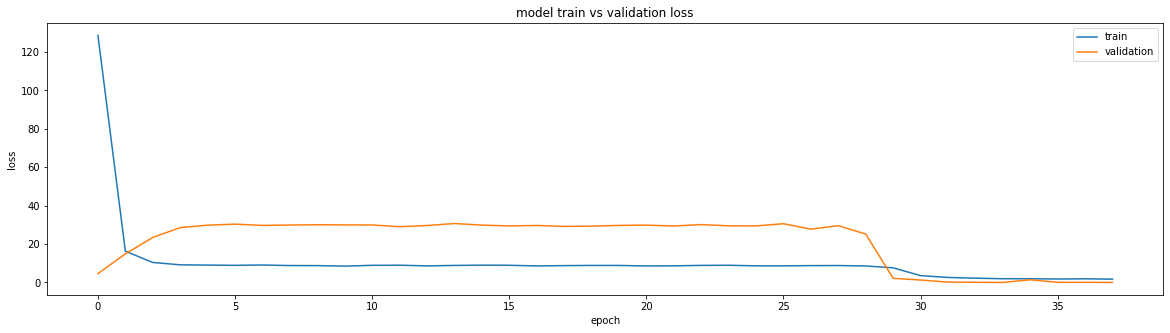

In [9]:
plt.plot(history.history[ 'loss' ]) 
plt.plot(history.history[ 'val_loss' ]) 
plt.title( 'model train vs validation loss' ) 
plt.ylabel( 'loss' ) 
plt.xlabel( 'epoch' ) 
plt.legend([ 'train' , 'validation' ], loc= 'upper right' ) 
plt.show()

In [10]:
y_pred = model.predict(X_test)

In [11]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Otwarcie'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie,
                        name='Truth',
                        marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=predicted_prices.Otwarcie,
                        name='Prediction',
                        marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_test,
                        name='Truth',
                        marker_color='LightSkyBlue',
                        showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=predicted_prices.Otwarcie,
                        name='Prediction',
                        marker_color='MediumPurple',
                        showlegend=False), row=2, col=1)

fig.show()

In [12]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 0.0421865926115036
MAE = 0.15520512072766413
RMSE = 0.2053937501763469


30 days of history data

In [13]:
x_label = ['Zamknięcie']
for i in range(1, 30):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)
X_train = train_df[x_label]
y_train = train_df['Otwarcie_1day']
X_test = test_df[x_label]
y_test = test_df['Otwarcie_1day']
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.values
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [14]:
seed(2022)
model = Sequential()


model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))


model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs = 346, batch_size = 250, validation_split=0.3)

Epoch 1/346
6/6 [==============================] - 6s 344ms/step - loss: 219.6775 - val_loss: 83.0766
Epoch 2/346
6/6 [==============================] - 1s 121ms/step - loss: 186.3177 - val_loss: 44.1894
Epoch 3/346
6/6 [==============================] - 1s 166ms/step - loss: 129.5064 - val_loss: 23.0383
Epoch 4/346
6/6 [==============================] - 1s 122ms/step - loss: 94.0979 - val_loss: 12.2519
Epoch 5/346
6/6 [==============================] - 1s 156ms/step - loss: 69.7468 - val_loss: 6.7766
Epoch 6/346
6/6 [==============================] - 1s 121ms/step - loss: 53.7806 - val_loss: 4.5224
Epoch 7/346
6/6 [==============================] - 1s 125ms/step - loss: 45.2032 - val_loss: 3.7555
Epoch 8/346
6/6 [==============================] - 1s 124ms/step - loss: 38.1687 - val_loss: 3.6524
Epoch 9/346
6/6 [==============================] - 1s 125ms/step - loss: 32.9368 - val_loss: 3.8920
Epoch 10/346
6/6 [==============================] - 1s 124ms/step - loss: 29.4168 - val_loss:

6/6 [==============================] - 1s 155ms/step - loss: 9.0231 - val_loss: 29.9453
Epoch 83/346
6/6 [==============================] - 1s 154ms/step - loss: 8.9803 - val_loss: 29.9460
Epoch 84/346
6/6 [==============================] - 1s 153ms/step - loss: 9.3252 - val_loss: 29.9034
Epoch 85/346
6/6 [==============================] - 1s 154ms/step - loss: 8.2960 - val_loss: 29.8799
Epoch 86/346
6/6 [==============================] - 1s 154ms/step - loss: 8.3508 - val_loss: 29.8645
Epoch 87/346
6/6 [==============================] - 1s 153ms/step - loss: 8.7750 - val_loss: 29.8876
Epoch 88/346
6/6 [==============================] - 1s 152ms/step - loss: 8.5096 - val_loss: 29.9380
Epoch 89/346
6/6 [==============================] - 1s 187ms/step - loss: 9.0697 - val_loss: 30.0304
Epoch 90/346
6/6 [==============================] - 1s 145ms/step - loss: 8.4771 - val_loss: 30.0444
Epoch 91/346
6/6 [==============================] - 1s 154ms/step - loss: 8.8977 - val_loss: 29.9895
Epo

6/6 [==============================] - 1s 163ms/step - loss: 8.6782 - val_loss: 30.2051
Epoch 163/346
6/6 [==============================] - 1s 179ms/step - loss: 9.1947 - val_loss: 30.1767
Epoch 164/346
6/6 [==============================] - 1s 149ms/step - loss: 8.8508 - val_loss: 30.0785
Epoch 165/346
6/6 [==============================] - 1s 155ms/step - loss: 8.5591 - val_loss: 29.9504
Epoch 166/346
6/6 [==============================] - 1s 154ms/step - loss: 9.2272 - val_loss: 29.9051
Epoch 167/346
6/6 [==============================] - 1s 154ms/step - loss: 8.6834 - val_loss: 29.7925
Epoch 168/346
6/6 [==============================] - 1s 153ms/step - loss: 8.9812 - val_loss: 29.8821
Epoch 169/346
6/6 [==============================] - 1s 155ms/step - loss: 8.9181 - val_loss: 29.9163
Epoch 170/346
6/6 [==============================] - 1s 154ms/step - loss: 8.8989 - val_loss: 29.9950
Epoch 171/346
6/6 [==============================] - 1s 154ms/step - loss: 8.9561 - val_loss: 30

6/6 [==============================] - 1s 165ms/step - loss: 8.5451 - val_loss: 30.1037
Epoch 243/346
6/6 [==============================] - 1s 146ms/step - loss: 8.8345 - val_loss: 30.0893
Epoch 244/346
6/6 [==============================] - 1s 155ms/step - loss: 8.3993 - val_loss: 30.0312
Epoch 245/346
6/6 [==============================] - 1s 157ms/step - loss: 8.6790 - val_loss: 30.0875
Epoch 246/346
6/6 [==============================] - 1s 155ms/step - loss: 8.6563 - val_loss: 30.1640
Epoch 247/346
6/6 [==============================] - 1s 155ms/step - loss: 8.6526 - val_loss: 30.2213
Epoch 248/346
6/6 [==============================] - 1s 156ms/step - loss: 8.6894 - val_loss: 30.1016
Epoch 249/346
6/6 [==============================] - 1s 188ms/step - loss: 8.8993 - val_loss: 30.0546
Epoch 250/346
6/6 [==============================] - 1s 148ms/step - loss: 8.9505 - val_loss: 29.9400
Epoch 251/346
6/6 [==============================] - 1s 154ms/step - loss: 8.5443 - val_loss: 29

Epoch 323/346
6/6 [==============================] - 1s 188ms/step - loss: 1.5803 - val_loss: 1.3710
Epoch 324/346
6/6 [==============================] - 1s 147ms/step - loss: 1.6742 - val_loss: 1.3640
Epoch 325/346
6/6 [==============================] - 1s 153ms/step - loss: 1.6789 - val_loss: 1.7317
Epoch 326/346
6/6 [==============================] - 1s 156ms/step - loss: 1.8260 - val_loss: 1.4965
Epoch 327/346
6/6 [==============================] - 1s 156ms/step - loss: 1.6181 - val_loss: 1.7086
Epoch 328/346
6/6 [==============================] - 1s 154ms/step - loss: 1.5966 - val_loss: 1.8711
Epoch 329/346
6/6 [==============================] - 1s 155ms/step - loss: 1.7678 - val_loss: 1.5467
Epoch 330/346
6/6 [==============================] - 1s 159ms/step - loss: 1.7636 - val_loss: 2.2220
Epoch 331/346
6/6 [==============================] - 1s 156ms/step - loss: 1.6856 - val_loss: 1.6067
Epoch 332/346
6/6 [==============================] - 1s 155ms/step - loss: 1.5505 - val_los

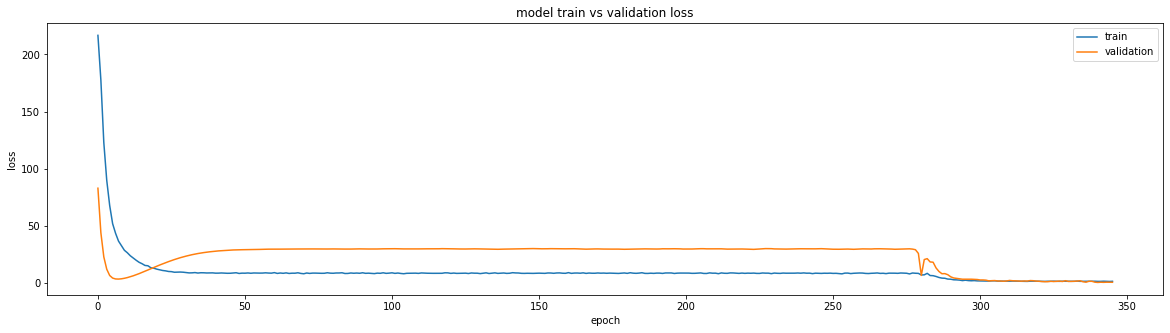

In [15]:
plt.plot(history.history[ 'loss' ]) 
plt.plot(history.history[ 'val_loss' ]) 
plt.title( 'model train vs validation loss' ) 
plt.ylabel( 'loss' ) 
plt.xlabel( 'epoch' ) 
plt.legend([ 'train' , 'validation' ], loc= 'upper right' ) 
plt.show()

In [16]:
y_pred = model.predict(X_test)

In [17]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Otwarcie'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie,
                        name='Truth',
                        marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=predicted_prices.Otwarcie,
                        name='Prediction',
                        marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_test,
                        name='Truth',
                        marker_color='LightSkyBlue',
                        showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=predicted_prices.Otwarcie,
                        name='Prediction',
                        marker_color='MediumPurple',
                        showlegend=False), row=2, col=1)

fig.show()

In [18]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 2.9631539440257075
MAE = 1.4213387796917902
RMSE = 1.721381405739503


## 7 days ahead

7 days of history data

In [19]:
x_label = ['Zamknięcie']
for i in range(1, 7):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)

y_label = []
for i in range(1, 8):
    label = 'Otwarcie_'+ str(i) + 'day'
    y_label.append(label)
X_train = train_df[x_label]
y_train = train_df[y_label].values
X_test = test_df[x_label]
y_test = test_df[y_label].values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

In [20]:
from numpy.random import seed
seed(2022)
model = Sequential()


model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))


model.add(Dense(y_train.shape[1]))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs = 45, batch_size = 32, validation_split=0.3)

Epoch 1/45
43/43 [==============================] - 8s 55ms/step - loss: 204.1158 - val_loss: 26.5655
Epoch 2/45
43/43 [==============================] - 1s 17ms/step - loss: 92.9369 - val_loss: 8.6556
Epoch 3/45
43/43 [==============================] - 1s 16ms/step - loss: 56.2637 - val_loss: 4.2609
Epoch 4/45
43/43 [==============================] - 1s 15ms/step - loss: 33.1559 - val_loss: 6.1411
Epoch 5/45
43/43 [==============================] - 1s 19ms/step - loss: 21.5136 - val_loss: 10.6755
Epoch 6/45
43/43 [==============================] - 1s 19ms/step - loss: 14.9238 - val_loss: 15.9108
Epoch 7/45
43/43 [==============================] - 1s 21ms/step - loss: 12.0516 - val_loss: 20.3401
Epoch 8/45
43/43 [==============================] - 1s 20ms/step - loss: 9.9324 - val_loss: 23.9450
Epoch 9/45
43/43 [==============================] - 1s 21ms/step - loss: 9.4368 - val_loss: 26.4114
Epoch 10/45
43/43 [==============================] - 1s 25ms/step - loss: 9.3834 - val_loss: 28

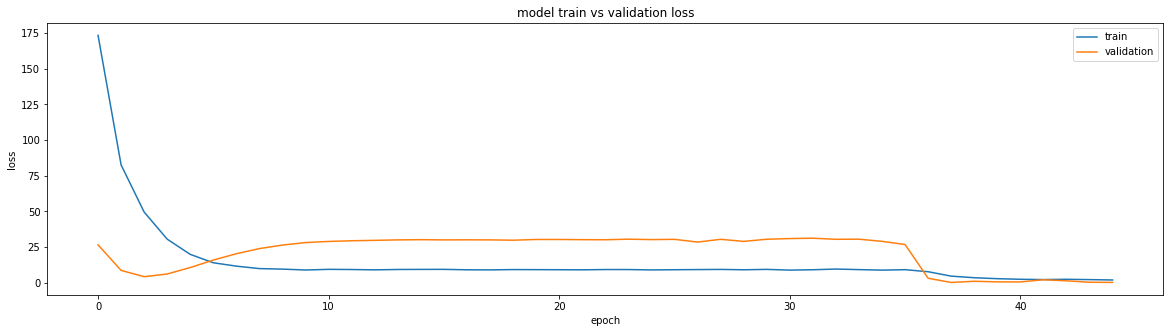

In [21]:
plt.plot(history.history[ 'loss' ]) 
plt.plot(history.history[ 'val_loss' ]) 
plt.title( 'model train vs validation loss' ) 
plt.ylabel( 'loss' ) 
plt.xlabel( 'epoch' ) 
plt.legend([ 'train' , 'validation' ], loc= 'upper right' ) 
plt.show()

In [22]:
y_pred = model.predict(X_test)

In [23]:
y_test = test_df[y_label].values

In [24]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 0.3355260186859605
MAE = 0.44596982542748226
RMSE = 0.5792460778339034


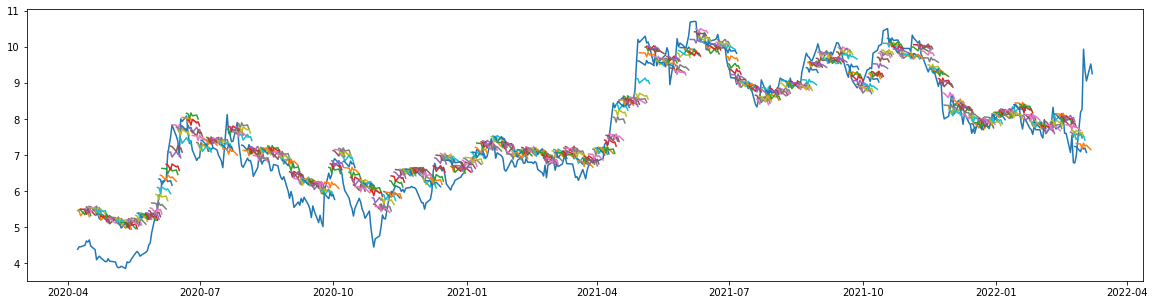

In [25]:
data = df.loc[test_split_idx+1:].Data
x_truth = data;
y_truth = test_df['Otwarcie_1day'];
plt.plot(x_truth, y_truth);
for i in range(len(y_pred)-7):
    x = data[i:i+7].tolist();
    y = y_pred[i];
    plt.plot(x, y);

30 days of history data

In [40]:
x_label = ['Zamknięcie']
for i in range(1, 30):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)

y_label = []
for i in range(1, 8):
    label = 'Otwarcie_'+ str(i) + 'day'
    y_label.append(label)
X_train = train_df[x_label]
y_train = train_df[y_label].values
X_test = test_df[x_label]
y_test = test_df[y_label].values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

In [41]:
from numpy.random import seed
seed(2022)
model = Sequential()


model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))


model.add(Dense(y_train.shape[1]))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs = 300, batch_size = 32, validation_split=0.3)

Epoch 1/300
43/43 [==============================] - 8s 86ms/step - loss: 194.4485 - val_loss: 29.4567
Epoch 2/300
43/43 [==============================] - 3s 60ms/step - loss: 97.9024 - val_loss: 10.6421
Epoch 3/300
43/43 [==============================] - 3s 65ms/step - loss: 61.0943 - val_loss: 5.1400
Epoch 4/300
43/43 [==============================] - 3s 61ms/step - loss: 37.3295 - val_loss: 5.8628
Epoch 5/300
43/43 [==============================] - 3s 66ms/step - loss: 24.5883 - val_loss: 9.5258
Epoch 6/300
43/43 [==============================] - 3s 64ms/step - loss: 16.8662 - val_loss: 14.2686
Epoch 7/300
43/43 [==============================] - 3s 60ms/step - loss: 13.3117 - val_loss: 18.5694
Epoch 8/300
43/43 [==============================] - 3s 65ms/step - loss: 10.5927 - val_loss: 22.3039
Epoch 9/300
43/43 [==============================] - 3s 58ms/step - loss: 9.6530 - val_loss: 25.0681
Epoch 10/300
43/43 [==============================] - 3s 66ms/step - loss: 9.6339 - v

43/43 [==============================] - 3s 72ms/step - loss: 8.8026 - val_loss: 29.5277
Epoch 82/300
43/43 [==============================] - 3s 69ms/step - loss: 9.1321 - val_loss: 30.0307
Epoch 83/300
43/43 [==============================] - 3s 58ms/step - loss: 8.8595 - val_loss: 30.9670
Epoch 84/300
43/43 [==============================] - 3s 69ms/step - loss: 8.8889 - val_loss: 31.1996
Epoch 85/300
43/43 [==============================] - 3s 69ms/step - loss: 8.9578 - val_loss: 30.3993
Epoch 86/300
43/43 [==============================] - 3s 64ms/step - loss: 8.7068 - val_loss: 30.0252
Epoch 87/300
43/43 [==============================] - 3s 67ms/step - loss: 8.7170 - val_loss: 30.1125
Epoch 88/300
43/43 [==============================] - 3s 64ms/step - loss: 8.5552 - val_loss: 29.9763
Epoch 89/300
43/43 [==============================] - 3s 70ms/step - loss: 8.5030 - val_loss: 30.6238
Epoch 90/300
43/43 [==============================] - 3s 61ms/step - loss: 8.6322 - val_loss: 3

43/43 [==============================] - 3s 73ms/step - loss: 1.9627 - val_loss: 7.7970
Epoch 162/300
43/43 [==============================] - 2s 57ms/step - loss: 2.0688 - val_loss: 23.3644
Epoch 163/300
43/43 [==============================] - 3s 70ms/step - loss: 1.8544 - val_loss: 2.8965
Epoch 164/300
43/43 [==============================] - 3s 74ms/step - loss: 1.6892 - val_loss: 2.0187
Epoch 165/300
43/43 [==============================] - 3s 71ms/step - loss: 1.6228 - val_loss: 1.6209
Epoch 166/300
43/43 [==============================] - 3s 69ms/step - loss: 1.7547 - val_loss: 1.3075
Epoch 167/300
43/43 [==============================] - 3s 58ms/step - loss: 1.5237 - val_loss: 1.0090
Epoch 168/300
43/43 [==============================] - 3s 73ms/step - loss: 1.7069 - val_loss: 1.1062
Epoch 169/300
43/43 [==============================] - 3s 68ms/step - loss: 1.6273 - val_loss: 1.5620
Epoch 170/300
43/43 [==============================] - 3s 66ms/step - loss: 1.7059 - val_loss: 

43/43 [==============================] - 3s 70ms/step - loss: 1.4585 - val_loss: 2.9453
Epoch 242/300
43/43 [==============================] - 3s 71ms/step - loss: 1.4303 - val_loss: 2.4914
Epoch 243/300
43/43 [==============================] - 3s 68ms/step - loss: 1.5242 - val_loss: 3.0207
Epoch 244/300
43/43 [==============================] - 3s 68ms/step - loss: 1.2300 - val_loss: 2.4957
Epoch 245/300
43/43 [==============================] - 3s 61ms/step - loss: 1.4790 - val_loss: 2.9615
Epoch 246/300
43/43 [==============================] - 3s 67ms/step - loss: 1.5486 - val_loss: 2.8730
Epoch 247/300
43/43 [==============================] - 3s 72ms/step - loss: 1.6427 - val_loss: 2.6576
Epoch 248/300
43/43 [==============================] - 3s 69ms/step - loss: 1.4013 - val_loss: 2.7561
Epoch 249/300
43/43 [==============================] - 3s 63ms/step - loss: 1.3926 - val_loss: 2.5890
Epoch 250/300
43/43 [==============================] - 3s 67ms/step - loss: 1.3744 - val_loss: 2

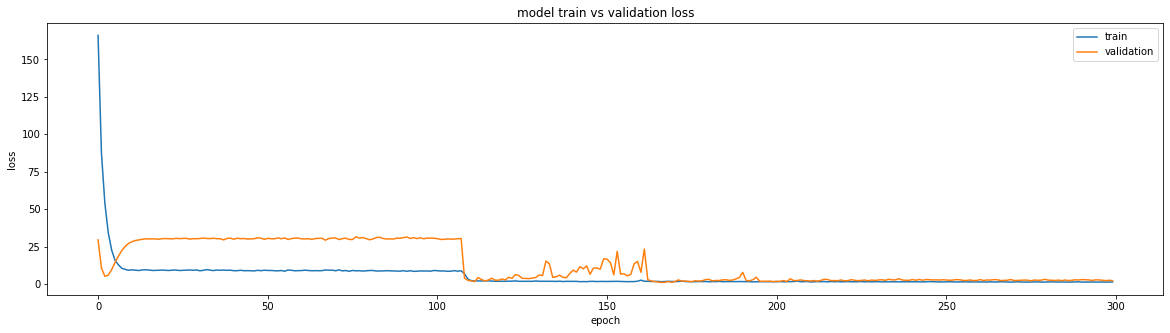

In [42]:
plt.plot(history.history[ 'loss' ]) 
plt.plot(history.history[ 'val_loss' ]) 
plt.title( 'model train vs validation loss' ) 
plt.ylabel( 'loss' ) 
plt.xlabel( 'epoch' ) 
plt.legend([ 'train' , 'validation' ], loc= 'upper right' ) 
plt.show()

In [43]:
y_pred = model.predict(X_test)

In [44]:
y_test = test_df[y_label].values

In [45]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 5.600771808840859
MAE = 1.8741646152357911
RMSE = 2.3665949820028054


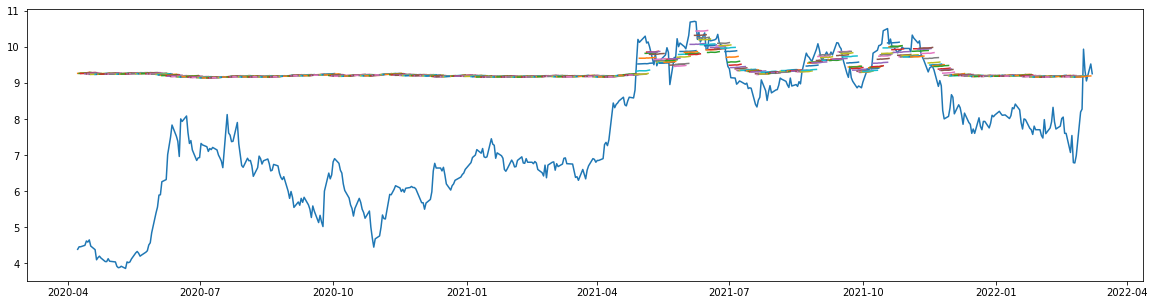

In [46]:
data = df.loc[test_split_idx+1:].Data;
x_truth = data;
y_truth = test_df['Otwarcie_1day'];
plt.plot(x_truth, y_truth);
for i in range(len(y_pred)-7):
    x = data[i:i+7].tolist()
    y = y_pred[i]
    plt.plot(x, y)